In [1]:
import argparse
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
from utils import *
import random
import numpy as np
import math
import os 
import scipy
import torch.nn as nn
from modified_stable_diffusion import ModifiedStableDiffusionPipeline
import PIL
import open_clip
from PIL import Image, ImageFilter
import commpy.utilities as util

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='diffusion watermark')
    parser.add_argument('--w_seed', default=0, type=int)
    # parser.add_argument('--dataset', default='Gustavosta/Stable-Diffusion-Prompts',choices=['coco','stablediffusionDB','Gustavosta/Stable-Diffusion-Prompts'])
    parser.add_argument('--dataset', default='coco')
    # parser.add_argument('--dataset', default='stablediffusionDB')
    parser.add_argument('--model_path', default='../stable-diffusion-2-1-base')
    # parser.add_argument('--model_path', default='../stable-diffusion-v1-4')
    parser.add_argument('--image_length', default=512, type=int)
    parser.add_argument('--secret_length', default=48, type=int)
    parser.add_argument('--num_inference_steps', default=25, type=int)
    parser.add_argument('--guidancescale', default=5, type=float)
    parser.add_argument('--reverse_inference_steps', default=25, type=int)
    args =parser.parse_known_args()[0]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    torch.set_printoptions(sci_mode=False,profile='full')
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    maxlength=150
    
# dataset
dataset, prompt_key = get_dataset(args)
dataset=promptdataset(dataset,prompt_key)
scheduler = DPMSolverMultistepScheduler.from_pretrained(args.model_path, subfolder='scheduler')
pipe = ModifiedStableDiffusionPipeline.from_pretrained(
        args.model_path,
        scheduler=scheduler,
        torch_dtype=torch.float16,
        revision='fp16',
        )
pipe = pipe.to(device)

from encoder_decoder_pretrain.watermark_model import *
encoder=Watermark(secret_length=args.secret_length).to(device)
encoder.load_state_dict(torch.load('./model48bit_finetuned.pth'))
encoder.eval()



import commpy.channelcoding.convcode as cc
memory = np.array(2, ndmin=1)
g_matrix = np.array((0o5, 0o7), ndmin=2)
trellis = cc.Trellis(memory, g_matrix)

import cv2
def measure_similarity(image, prompt, model, clip_preprocess, tokenizer, device):
    with torch.no_grad():
        image = clip_preprocess(image).unsqueeze(0).to(device)
        image_features = model.encode_image(image).to(device)
        
        text = tokenizer([prompt]).to(device)
        
        text_features = model.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return (image_features @ text_features.T).mean(-1)
    
def compute_local_contrast(image):
    mean = cv2.boxFilter(image, -1, (3, 3))
    mean_sq = cv2.boxFilter(image ** 2, -1, (3, 3))
    local_contrast = np.sqrt(mean_sq - mean ** 2)
    return local_contrast

def compute_niqe_score(image):
    local_contrast = compute_local_contrast(image)
    mean_contrast = np.mean(local_contrast)
    std_contrast = np.std(local_contrast)
    niqe_score = std_contrast / mean_contrast
    return niqe_score



        
ref_model, _, ref_clip_preprocess = open_clip.create_model_and_transforms('ViT-g-14', pretrained='../CLIP-ViT-g-14-laion2B-s12B-b42K/open_clip_pytorch_model.bin', device=device)
ref_tokenizer = open_clip.get_tokenizer('ViT-g-14')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: './model48bit_finetuned.pth'

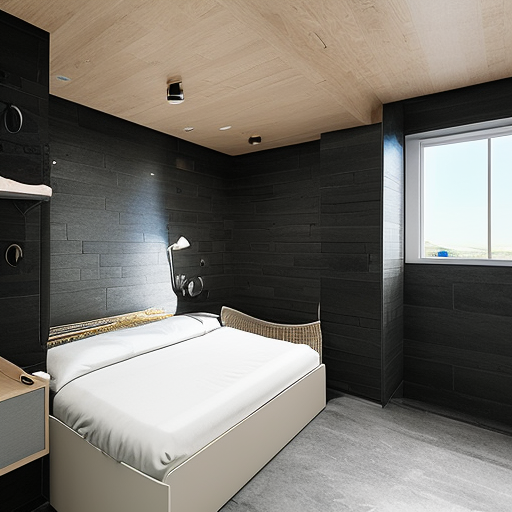

In [ ]:
Metric,Loss,Error_correct,pred,target,Sim,Piqe,Niqe=[],[],[],[],[],[],[],[]

for t in tqdm(range(1)):
    initial_latents=get_random_latents(pipe,args)
    init_latents=initial_latents.detach().clone()
    secret_ori=np.random.choice([0, 1], size=(args.secret_length//2))
    secret = cc.conv_encode(secret_ori,trellis,'cont')
    secret_dec=secret.copy()
    secret = torch.Tensor(secret).unsqueeze(-1).unsqueeze(-1).unsqueeze(0).to(device)
    secret = secret.expand(-1,-1,64,64)
    matrix1,mean,logvar=encoder(secret)
    mean=mean.reshape(-1,4,64,64)
    logvar=logvar.reshape(-1,4,64,64)
    eps = torch.randn_like(logvar)
    std = torch.exp(logvar / 2)
    matrix = eps * std + mean
    init_latents=matrix.half()

    # prompt=dataset[random.randint(1, len(dataset))][0:maxlength]
    prompt=dataset[t*20+140][0:maxlength]
    print(f"current prompt: {prompt}")
    img1= pipe(prompt=prompt,num_inference_steps=args.num_inference_steps,\
    latents=init_latents,guidance_scale=args.guidancescale).images[0]
    img1.show()
    sim=measure_similarity(img1, prompt, ref_model, ref_clip_preprocess, ref_tokenizer, device)
    Sim.append(sim[0].detach().cpu().numpy())
    # print(sim)
    
    import pypiqe
    piqescore=pypiqe.piqe(np.array(img1))[0]
    Piqe.append(piqescore)
    # gray_image=img1.convert('L')
    # cv2_image = cv2.cvtColor(np.array(gray_image), cv2.COLOR_GRAY2BGR)
    # niqescore=compute_niqe_score(cv2_image)
    
    import pyiqa
    niqe_metric = pyiqa.create_metric('niqe')
    niqescore=niqe_metric(img1)
    Niqe.append(niqescore.detach().cpu().numpy())
    img1.save('./sav.png')
    # img1.save(f'{secret_dec}.png')
    
    # img= pipe(prompt=prompt,num_inference_steps=args.num_inference_steps,\
    #     latents=initial_latents,guidance_scale=args.guidancescale).images[0]
    
    # img1=compress_jpeg_to_pil(img1, 50)
    
    # img1 = img1.resize((int(args.image_length*0.3), int(args.image_length*0.3)), PIL.Image.BICUBIC)
    
    # img1 = img1.filter(ImageFilter.GaussianBlur(radius=5))
    
    # from PIL import ImageEnhance
    # enhancer = ImageEnhance.Contrast(img1)
    # factor = 1.5
    # img1= enhancer.enhance(factor)
    
    # img1 = np.array(img1, dtype=np.uint16)
    # g_noise = np.random.randn(*img1.shape).astype(np.uint8)*0.5 
    # noisy_array = np.clip(img1.astype(np.uint16) + g_noise, 0, 255).astype(np.uint8)
    # img1 = Image.fromarray(noisy_array)
    
    # g_noise = (np.random.normal(0, 0.001, np.array(img1).shape) * 255).astype(np.uint8)
    # img1 = Image.fromarray(np.clip(np.array(img1, dtype=np.int16) + g_noise, 0, 255).astype(np.uint8))
    
    # img1 = transforms.ColorJitter(brightness=2)(img1)
    
    # import cv2
    # from bm3d import bm3d_rgb
    # rgb_array = np.array(img1)
    # denoised_red = bm3d_rgb(rgb_array,sigma_psd=30)
    # img1 = Image.fromarray(denoised_red.astype(np.uint8))
    
    
    
    
    reverse_latents=reverse(img1,pipe,args).float()
    reverse_latents = reverse_latents.view(1, -1)
    x = encoder.decoder_projection(reverse_latents)
    x = torch.reshape(x, (-1, *encoder.decoder_input_chw))
    average_tensor1 = torch.mean(secret, dim=(-2, -1))
    average_tensor2 = torch.round(torch.mean(encoder.decoder(x), dim=(-2, -1)))
    average_tensor3 = torch.mean(encoder.decoder(x), dim=(-2, -1))
    matrix_ori=torch.mean(matrix1, dim=(-2, -1))
  
    biterror=torch.sum(abs(average_tensor1-average_tensor2))
    mse_loss = torch.nn.MSELoss()
    loss = mse_loss(average_tensor3, average_tensor1)
    
    decoded_bits = cc.viterbi_decode(np.array(average_tensor2[0].detach().cpu()).astype(float), trellis, 5)
    num_bit_errors = util.hamming_dist(secret_ori, decoded_bits[:args.secret_length//2])
    Error_correct.append(num_bit_errors)
    
    pred.append(average_tensor1.cpu().detach().numpy())
    target.append(average_tensor2.cpu().detach().numpy())
    Metric.append(biterror)
    Loss.append(loss)
    
biterror=torch.mean(torch.stack(Metric))
biterrper=biterror/args.secret_length
metric=torch.mean(torch.stack(Loss))
correctbit_err=np.mean(Error_correct)
print(f'loss bits',f'{biterror.cpu().detach().numpy()}')
print(f'bit acc percentage {(1-biterrper)*100:.2f}%')
print(f'loss',f'{metric.cpu().detach()}')
print(f'bit error average',f'{biterror.detach().cpu().numpy():.2f}')
print(f'bit error correct average',f'{correctbit_err:.2f}')
print(f'Clip score average',f'{np.mean(Sim):.4f}')
print(f'NIQE score average',f'{np.mean(Niqe):.4f}')
print(f'PIQE score average',f'{np.mean(Piqe):.4f}')